# Kaggle Baseline Model

In this notebool we will the kaggle baseline model, with explanations and some improvement

### Import librairies

In [40]:
import pandas as pd
import numpy as np
from tqdm.notebook import  tqdm

import gc # for cleaning

import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

import optuna

In [2]:
# some configurations
BASE_FOLDER = '../../data/godaddy-microbusiness-density-forecasting'


### Useful functions

In [48]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * smap

### Load data

In [49]:
census = pd.read_csv(f'{BASE_FOLDER}/census_interpolated.csv')
census['first_day_of_month'] = pd.to_datetime(census['first_day_of_month'])
census = census.drop(columns = ['year'])
census.head()

,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,cfips,first_day_of_month
0,76.600000,14.500000,2.100000,1.300000,55317.000000,1001,2019-01-01
1,76.791667,14.616667,2.091667,1.283333,55606.083333,1001,2019-02-01
2,76.983333,14.733333,2.083333,1.266667,55895.166667,1001,2019-03-01
3,77.175000,14.850000,2.075000,1.250000,56184.250000,1001,2019-04-01
4,77.366667,14.966667,2.066667,1.233333,56473.333333,1001,2019-05-01


In [50]:
train = pd.read_csv(BASE_FOLDER + '/train.csv')
test = pd.read_csv(BASE_FOLDER + '/test.csv')
sub = pd.read_csv(BASE_FOLDER + '/sample_submission.csv')

print(f'train = {train.shape}')
print(f'test = {test.shape}')
print(f'sub = {sub.shape}')

train = (122265, 7)
test = (25080, 3)
sub = (25080, 2)


In [51]:
# merge train and test
train['istest'] = 0
test['istest'] = 1

raw = pd.concat((train, test)).sort_values(['cfips', 'row_id']).reset_index(drop = True)

# some formatting
raw['first_day_of_month'] = pd.to_datetime(raw['first_day_of_month'])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw['year'] = raw['first_day_of_month'].dt.year
raw['month'] = raw['first_day_of_month'].dt.month
raw['dcount'] = raw.groupby(['cfips'])['row_id'].cumcount() # timestep for every cfipis
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]

### Remove outliers and some anomalies

<AxesSubplot:xlabel='dcount'>

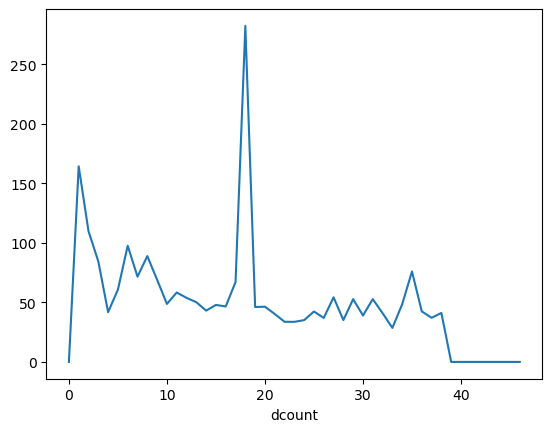

In [52]:
# check if there are huge variations between two consecutive months

lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill() # previous month
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1 # relative difference with previous month
raw.loc[(raw[f'mbd_lag_{lag}'] == 0), 'dif'] = 0 # if previous month is 0, then the relative difference is 0
raw.loc[ (raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}'] == 0), 'dif' ] = 1 # if previous month is 0 and current month is not 0, then the relative difference is 1
raw['dif'] = raw['dif'].abs() # want only to see the absolute difference

raw.groupby('dcount')['dif'].sum().plot() # plot the sum of the absolute difference for each timestep

### We can clearly see that there are some anomalies, specially at time step 18

In [53]:
# Check for outliers and normalize them

outliers = []

cnt = 0
for o in tqdm(raw.cfips.unique()): # for each county

    indices = (raw['cfips'] == o) # indices of the current county

    tmp = raw.loc[indices].copy().reset_index(drop = True) # current county
    var = tmp.microbusiness_density.values.copy() # microbusiness density of the current county

    for i in range(37, 2, -1): # for each timestep except the last one known (38)

        thr = 0.20 * np.mean(var[:i]) # 20% of the mean of the previous values
        difa = abs(var[i] - var[i-1]) # absolute difference with the previous value
        if (difa >= thr): # if the variation is too big
            var[:i] *= (var[i]/var[i-1]) # normalize the previous values
            outliers.append(o) # add the county to the outliers list
            cnt += 1 # increment the number of outliers
    var[0] = var[1] * 0.99 # why ?
    raw.loc[indices, 'microbusiness_density'] = var # update the microbusiness density of the current county

outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:18: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= (var[i]/var[i-1]) # normalize the previous values
C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i]/var[i-1]) # normalize the previous values
C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:18: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1]) # normalize the previous values
C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:16: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i] - var[i-1]) # absolute difference with the previous value


(481, 732)

<AxesSubplot:xlabel='dcount'>

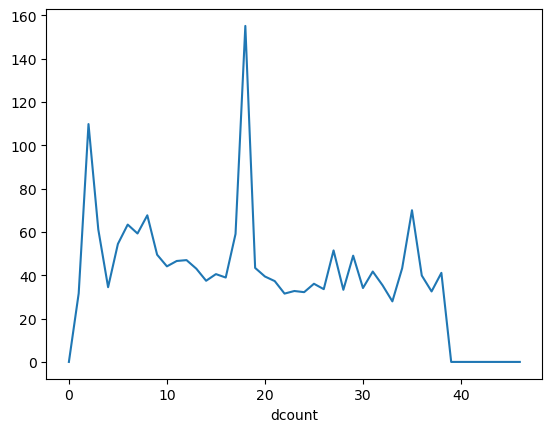

In [54]:
# display againt the sum of the absolute difference for each timestep

lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()

raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot:xlabel='dcount'>

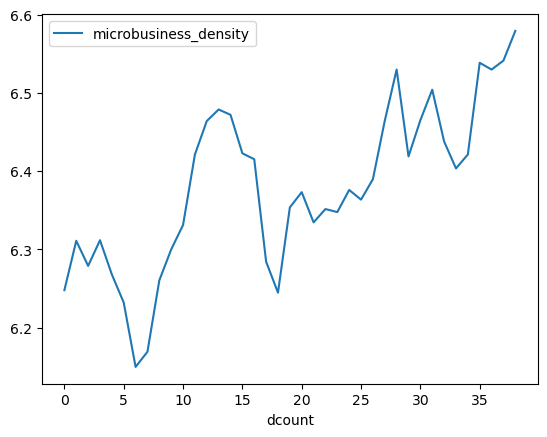

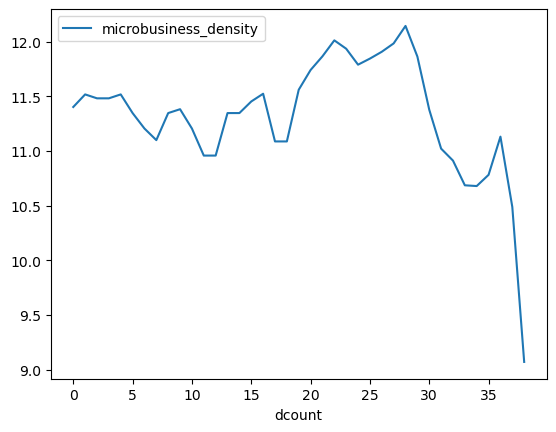

In [55]:
raw.loc[raw.cfips == 1089].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

### Convert Target

<AxesSubplot:>

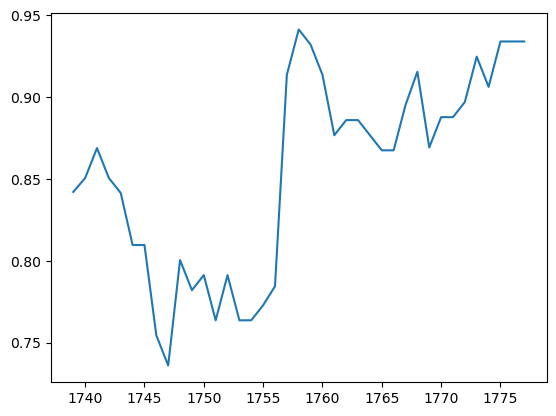

In [56]:
raw.loc[raw['cfips'] == 1075]['microbusiness_density'].plot()

In [57]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target'] / raw['microbusiness_density'] - 1

raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

raw.iloc[-20:,:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif,target
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50,1.670559,0.053763,0.020408
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50,1.760374,0.020408,-0.025949
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50,1.796300,0.025949,0.000000
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50,1.749688,0.000000,0.010204
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50,1.749688,0.010204,0.000000
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50,1.767542,0.000000,0.020202
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50,1.767542,0.020202,0.000000
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50,1.803249,0.000000,0.000000
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50,1.803249,0.000000,-0.009901
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50,1.803249,0.009901,0.000000


<AxesSubplot:>

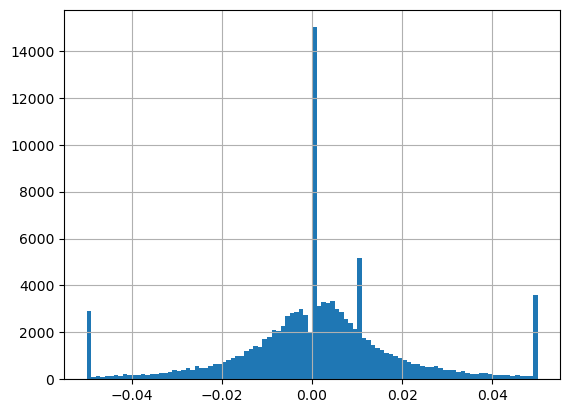

In [58]:
raw['target'].clip(-0.05, 0.05).hist(bins=100)

<AxesSubplot:>

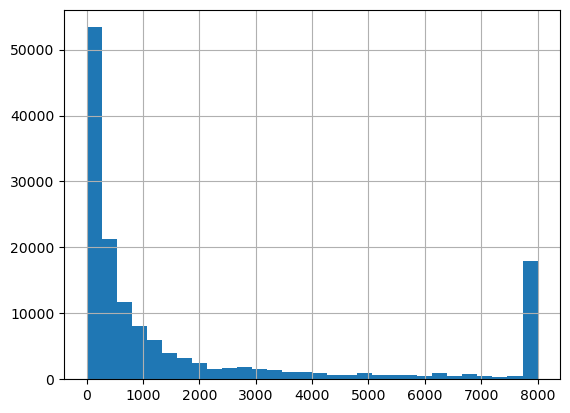

In [59]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

dt = raw.loc[raw.dcount == 28].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)

raw['lastactive'].clip(0,8000).hist(bins = 30)

### Features engineering

In [60]:
def build_features(raw, target='microbusiness_density', target_act = 'active_tmp', lags = 6):

    feats = []

    for lag in range(1, lags):

        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')

    lag = 1
    for window in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(
            lambda s : s.rolling(window, min_periods = 1).sum())
        raw[f'act_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'act_lag_{lag}'].transform(
            lambda s : s.rolling(window, min_periods = 1).sum())
        feats.append(f'mbd_rollmea{window}_{lag}')
        feats.append(f'act_rollmea{window}_{lag}')

    census_columns = list(census.columns)
    census_columns.remove('cfips')
    census_columns.remove('first_day_of_month')

    raw = raw.merge(census, on=['cfips', 'first_day_of_month'], how='left')
    feats += census_columns


    return raw, feats

In [61]:
# build features
raw, feats = build_features(raw, 'target', 'active', lags = 6)
features = ['state_i']
features += feats

print(features)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_lag_4', 'act_lag_4', 'mbd_lag_5', 'act_lag_5', 'mbd_rollmea2_1', 'act_rollmea2_1', 'mbd_rollmea3_1', 'act_rollmea3_1', 'mbd_rollmea4_1', 'act_rollmea4_1', 'mbd_rollmea5_1', 'act_rollmea5_1', 'mbd_rollmea6_1', 'act_rollmea6_1', 'mbd_rollmea7_1', 'act_rollmea7_1', 'mbd_rollmea8_1', 'act_rollmea8_1', 'mbd_rollmea9_1', 'act_rollmea9_1', 'mbd_rollmea10_1', 'act_rollmea10_1', 'pct_bb', 'pct_college', 'pct_foreign_born', 'pct_it_workers', 'median_hh_inc']


<AxesSubplot:>

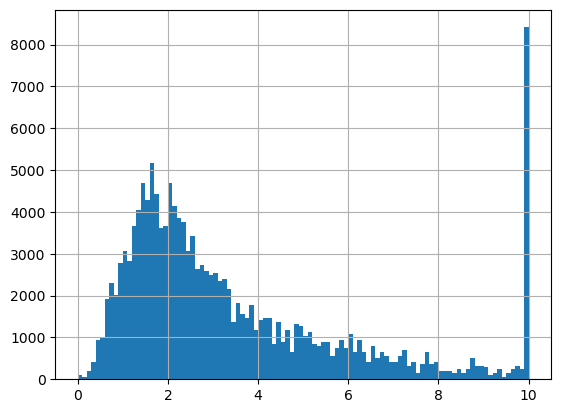

In [62]:
raw['lasttarget'].clip(0,10).hist(bins=100)

### Modeling

In [63]:
def get_model():

    params = {
        'n_iter' : 200,
        'verbosity' : -1,
        'objective' : 'l1',
        'random_state' : 77,
        'colsample_bytree': 0.8841,
        'colsample_bynode' : 0.10142,
        'max_depth' : 8,
        'learning_rate': 0.013364,
        'lambda_l1': 1.83862,
        'lambda_l2': 7.5576,
        'num_leaves': 61,
        'seed' : 77,
        'min_data_in_leaf' : 213
    }

    lgb_model = lgb.LGBMRegressor(**params)


    xgb_model = xgb.XGBRegressor(
        objective = 'reg:pseudohubererror',
        tree_method = 'hist',
        n_estimators = 795,
        learning_rate = 0.0075,
        max_leaves = 17,
        subsample =0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs = 2
    )

    cat_model = cat.CatBoostRegressor(
        iterations = 1200,
        loss_function = 'MAPE',
        verbose = 0,
        learning_rate = 0.075,
        l2_leaf_reg = 0.2,
        subsample = 0.50,
        max_bin=4096
    )

    #     gbr_model = Pipeline(
    #         [
    #             ('imputer',  KNNImputer(n_neighbors=2)),
    #             (
    #                 'gbr', GradientBoostingRegressor(
    #                     learning_rate = 0.08,
    #                     n_estimators = 800,
    #                     subsample = 0.5, max_depth = 9,
    #                     loss = 'huber',random_state = 42
    #                 )
    #             )
    #         ]
    #     )

    #     rf_model = Pipeline([
    #         ('imputer',  KNNImputer(n_neighbors=2)),
    #         ('rf', RandomForestRegressor(
    #             n_estimators = 800,
    #             criterion="absolute_error",
    #         ))
    #     ])

    knn_model = Pipeline([
        ('imputer', KNNImputer(n_neighbors=2)),
        ('knn', KNeighborsRegressor(5))
    ])

    return VotingRegressor([
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cat_model),
        ('knn', knn_model),
        #('gbr', gbr_model),
        #('rf', rf_model)
    ])

##### Blacklist

In [64]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]

blacklistcfips = [
    1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
    12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
    28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]

ACT_THR = 140
ABS_THR = 0
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1
VAL = []


In [65]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount == 18), ['microbusiness_density', 'ypred', 'error', 'error_last']]

,microbusiness_density,ypred,error,error_last
18,3.106106,NaN,NaN,NaN
65,7.909001,NaN,NaN,NaN
112,1.072105,NaN,NaN,NaN
159,1.287650,NaN,NaN,NaN
206,1.688793,NaN,NaN,NaN
...,...,...,...,...
147128,3.534121,NaN,NaN,NaN
147175,25.209639,NaN,NaN,NaN
147222,3.467531,NaN,NaN,NaN
147269,3.141015,NaN,NaN,NaN


In [66]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt = dt.groupby('cfips')['miss'].mean()
dt = dt.loc[dt>=0.50]
dt.shape

C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\2960438224.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()


(0,)

In [67]:
# model loop
TS = 38

model0 = get_model()
#model1 = get_model()

train_indices = (raw.istest ==0) & (raw.dcount < TS ) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) & (raw.lasttarget>ABS_THR)
valid_indices = (raw.dcount == TS)

model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.00435, 0.0046),
)
# model1.fit(
#     raw.loc[train_indices, features],
#     raw.loc[train_indices, 'target'].clip(-0.00435, 0.0046),
# )

ypred = model0.predict(raw.loc[valid_indices, features])

raw.loc[valid_indices, 'k'] = ypred + 1
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

C:\Users\avomo\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] seed is set=77, random_state=77 will be ignored. Current value: seed=77
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] lambda_l1 is set=1.83862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.83862
[LightGBM] [Warning] lambda_l2 is set=7.5576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5576
[LightGBM] [Warning] num_iterations is set=200, n_iter=200 will be ignored. Current value: num_iterations=200


In [68]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)


df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']

raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [69]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].tail(20)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k
147325,56045,1.760374,27,NaN,NaN,1.000000
147326,56045,1.796300,28,NaN,NaN,1.000000
147327,56045,1.749688,29,NaN,NaN,1.000000
147328,56045,1.749688,30,NaN,NaN,1.000000
147329,56045,1.767542,31,NaN,NaN,1.000000
147330,56045,1.767542,32,NaN,NaN,1.000000
147331,56045,1.803249,33,NaN,NaN,1.000000
147332,56045,1.803249,34,NaN,NaN,1.000000
147333,56045,1.803249,35,NaN,NaN,1.000000
147334,56045,1.785395,36,NaN,NaN,1.000000


In [70]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

test = test[['row_id','microbusiness_density']]

In [71]:
test.to_csv('submission_3.csv', index=False)
test.head()

,row_id,microbusiness_density
39,1001_2022-11-01,3.464352
40,1001_2022-12-01,3.464352
41,1001_2023-01-01,3.464352
42,1001_2023-02-01,3.464352
43,1001_2023-03-01,3.464352
